#Hyperparameters and imports


In [ ]:
import torch
from torch import nn
from torch.nn import functional

import sklearn
from sklearn import model_selection

import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.optim as optim

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
from torch.utils.data import Subset

import matplotlib.pyplot as plt

import os
import pickle
import numpy as np
import math

import skimage as ski
import skimage.io

from google.colab import drive

drive.mount('/content/drive')

ROOT_DIR='/content/drive/My Drive/Colab Notebooks/Pseudolabelv1_data'

batch_size_labeled = 20
batch_size_unlabeled = 200

labeled_num = 4000 #Broj označenih slika na kojima ćemo trenirati

num_epochs = 130

T1 = 75
T2 = 120

learning_rate = 0.001
weight_decay = 0.005
gamma = 0.95

alpha_f = 3 #faktor s kojim množimo loss na neoznačenom skupu (ovo je maksimalna vrijednost, raste linearno od epohe T1 do epohe T2)

Mounted at /content/drive


#Model

In [ ]:
class ConvolutionalModel(nn.Module):
  def __init__(self, in_channels, conv1_width, fc1_width, class_count):
    super(ConvolutionalModel, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, conv1_width, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv1_bn = nn.BatchNorm2d(conv1_width)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(conv1_width, conv1_width * 2, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv2_bn = nn.BatchNorm2d(conv1_width*2)

    self.fc1 = nn.Linear(fc1_width * 16, fc1_width * 2, bias=True)
    self.fc1_bn = nn.BatchNorm1d(fc1_width * 2)
    self.fc2 = nn.Linear(fc1_width * 2, fc1_width, bias=True)
    self.fc2_bn = nn.BatchNorm1d(fc1_width)
    self.fc_logits = nn.Linear(fc1_width, class_count, bias=True)

  
  def forward(self, x):
    h = self.conv1(x)
    h = functional.relu(h)
    h = self.conv1_bn(h)
    h = self.pool1(h)

    h = self.conv2(h)
    h = functional.relu(h)
    h = self.conv2_bn(h)
    h = self.pool1(h)

    h = h.view(h.shape[0], -1)

    h = self.fc1(h)
    h = functional.relu(h)
    h = self.fc1_bn(h)

    h = self.fc2(h)
    h = functional.relu(h)
    h = self.fc2_bn(h)
    logits = self.fc_logits(h)
    return logits

#Plot

In [ ]:
def plot_training_progress(save_dir, data, batch_size):
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

  linewidth = 2
  legend_size = 10
  train_color = 'm'
  val_color = 'c'

  num_points = len(data['train_loss'])
  x_data = np.linspace(1, num_points, num_points)
  ax1.set_title('Cross-entropy loss')
  ax1.plot(x_data, data['train_loss'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax1.plot(x_data, data['valid_loss'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax1.legend(loc='upper right', fontsize=legend_size)
  ax2.set_title('Average class accuracy')
  ax2.plot(x_data, data['train_acc'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='train')
  ax2.plot(x_data, data['valid_acc'], marker='o', color=val_color,
           linewidth=linewidth, linestyle='-', label='validation')
  ax2.legend(loc='upper left', fontsize=legend_size)
  ax3.set_title('Learning rate')
  ax3.plot(x_data, data['lr'], marker='o', color=train_color,
           linewidth=linewidth, linestyle='-', label='learning_rate')
  ax3.legend(loc='upper left', fontsize=legend_size)

  save_path = os.path.join(save_dir, ('training_plot_batch_size_' + str(batch_size) + '.png'))
  print('Plotting in: ', save_path)
  plt.savefig(save_path)


def draw_conv_filters(epoch, step, weights, save_dir):
  w = weights.copy()
  num_filters = w.shape[0]
  num_channels = w.shape[1]
  k = w.shape[2]
  assert w.shape[3] == w.shape[2]
  w = w.transpose(2, 3, 1, 0)
  w -= w.min()
  w /= w.max()
  border = 1
  cols = 8
  rows = math.ceil(num_filters / cols)
  width = cols * k + (cols-1) * border
  height = rows * k + (rows-1) * border
  img = np.zeros([height, width, num_channels])
  for i in range(num_filters):
    r = int(i / cols) * (k + border)
    c = int(i % cols) * (k + border)
    img[r:r+k,c:c+k,:] = w[:,:,:,i]
  filename = 'epoch_%02d_step_%06d.png' % (epoch, step)
  ski.io.imsave(os.path.join(save_dir, filename), img)

#Data load

In [ ]:
MEAN = [0.49139968, 0.48215827, 0.44653124]
STD = [0.24703233, 0.24348505, 0.26158768]

toTensor = transforms.ToTensor()
normalize = transforms.Normalize(MEAN, STD)
flipTransform = transforms.RandomHorizontalFlip(p=0.4)
affineTransform = transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.5)
PILTransform = transforms.ToPILImage()

trainTransform = transforms.Compose([flipTransform, transforms.RandomApply([affineTransform], p=0.8), toTensor, normalize])
validTransform = transforms.Compose([toTensor, normalize])

trainset = torchvision.datasets.CIFAR10(root=ROOT_DIR + '/data', train=True,
                                        download=True, transform=trainTransform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                         shuffle=True, num_workers=0)

samples_per_class = int(labeled_num/10)

targets = trainset.targets
targets = np.array(targets, dtype=np.int_)

labeled_i = np.where(targets == 0)[0][:samples_per_class]
unlabeled_i = np.where(targets == 0)[0][samples_per_class:]

for i in range(1,10):
    labeled_i = np.append(labeled_i, np.where(targets == i)[0][:samples_per_class])
    unlabeled_i = np.append(unlabeled_i, np.where(targets == i)[0][samples_per_class:])

labeled = Subset(trainset, labeled_i)
unlabeled = Subset(trainset, unlabeled_i)

# x_labeled, x_unlabeled, y_labeled, y_unlabeled = model_selection.train_test_split(trainset.data, trainset.targets, train_size = labeled_num, stratify = trainset.targets)

# x_labeled = torch.Tensor(x_labeled)
# x_labeled = x_labeled.permute(0,3,1,2)
# for i in range(x_labeled.shape[0]):
#   img = PILTransform(x_labeled[i])
#   x_labeled[i] = trainTransform(img)


# y_labeled = torch.LongTensor(y_labeled)

# x_unlabeled = torch.Tensor(x_unlabeled)
# x_unlabeled = x_unlabeled.permute(0,3,1,2)
# for i in range(x_unlabeled.shape[0]):
#   img = PILTransform(x_unlabeled[i])
#   x_unlabeled[i] = trainTransform(img)
# y_unlabeled = torch.LongTensor(y_unlabeled)

# labeled = TensorDataset(x_labeled, y_labeled)
# unlabeled = TensorDataset(x_unlabeled, y_unlabeled)


labeled_loader = torch.utils.data.DataLoader(labeled, batch_size=batch_size_labeled,
                                          shuffle=True, num_workers=0)

unlabeled_loader = torch.utils.data.DataLoader(unlabeled, batch_size=batch_size_unlabeled,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root=ROOT_DIR + '/data', train=False,
                                       download=True, transform=validTransform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_unlabeled,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting /content/drive/My Drive/Colab Notebooks/Pseudolabelv1_data/data/cifar-10-python.tar.gz to /content/drive/My Drive/Colab Notebooks/Pseudolabelv1_data/data
Files already downloaded and verified


#Evaluate

In [ ]:
def evaluate(model, loader, loss_fn):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    correct = 0
    confMatrix = np.zeros((10, 10), int)
    loss_avg = 0.0
    total = 0

    with torch.no_grad():
        model.eval()
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs, dim=1)
              
            total +=labels.shape[0]
            correct += int((predicted == labels).sum())
            loss_avg += loss.item()
            for j in range(labels.size(0)):
                    confMatrix[predicted[j], labels[j]] += 1

    acc = correct / total
    loss_avg /= len(loader)
    model.train()
    
    return loss_avg, acc, confMatrix;

def specificMetrics(confMatrix):
    for i in range(np.size(confMatrix, 0)):
        print("Class: " + classes[i], end='')
        precc = 0
        recal = 0
        tp = 0
        fp = 0
        fn = 0
        for j in range(np.size(confMatrix, 0)):
            if i == j:
                tp += confMatrix[i, j]
            else:
                fn += confMatrix[j, i]
                fp += confMatrix[i, j]
            
        precc = tp/(tp + fp)
        recal = tp/(tp + fn)

        print(", Precision: %.2f, Recall: %.2f" %(precc, recal))

#Alpha

In [ ]:
def alpha(t, t1, t2):
  if t < t1:
    return 0
  elif t < t2:
    return ((t-t1)/(t2-t1))*alpha_f
  else:
    return alpha_f

#Train normally (samo za provjeru radi li sve dobro bez pseudooznačavanja)


In [ ]:
def trainNetwork():
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []
    SAVE_DIR = '/content/drive/My Drive/Colab Notebooks/ProjektR_data/plots'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    net = ConvolutionalModel(3, 16, 128, 10).to(device=device)

    lossFunc = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    epoch = 20
    

    for e in range(epoch):
    
        accLoss = 0.0

        for i, data in enumerate(labeled_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            
            outputs = net.forward(inputs)
            loss = lossFunc(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            accLoss += loss.item()

            if i % 10 == 0:
                print("Epoch: %d, Iteration: %5d, Loss: %.3f" % ((e + 1), (i), (accLoss / (i + 1))))
                
        train_loss, train_acc, trainconf = evaluate(net, trainloader, lossFunc)
        val_loss, val_acc, valconf = evaluate(net, testloader, lossFunc)

        print('Epoch: {}, Training loss: {}, Training accuracy: {}'.format(e+1, train_loss, train_acc))
        print(trainconf)

        print('Epoch: {}, Test loss: {}, Test accuracy: {}'.format(e+1, val_loss, val_acc))
        print(valconf)

        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [val_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [val_acc]
        plot_data['lr'] += [scheduler.get_lr()]

        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [val_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [val_acc]
        plot_data['lr'] += [scheduler.get_lr()]

        scheduler.step()

    plot_training_progress(SAVE_DIR, plot_data, b_s)
    PATH = '/content/drive/My Drive/Colab Notebooks/ProjektR_data/network/'+str(b_s)+'_netAdam.pth'
    torch.save(net.state_dict(), PATH)


trainNetwork()

Epoch: 1, Iteration:     0, Loss: 2.301
Epoch: 1, Iteration:    10, Loss: 2.243
Epoch: 1, Iteration:    20, Loss: 2.155
Epoch: 1, Iteration:    30, Loss: 2.109
Epoch: 1, Iteration:    40, Loss: 2.077
Epoch: 1, Iteration:    50, Loss: 2.049
Epoch: 1, Iteration:    60, Loss: 2.022
Epoch: 1, Iteration:    70, Loss: 2.002
Epoch: 1, Iteration:    80, Loss: 1.988
Epoch: 1, Iteration:    90, Loss: 1.965


KeyboardInterrupt: ignored

#Train

alpha_f = 1
Epoch: 1, Labeled iteration:    10, Loss: 2.231
Epoch: 1, Labeled iteration:    20, Loss: 2.150
Epoch: 1, Labeled iteration:    30, Loss: 2.107
Epoch: 1, Labeled iteration:    40, Loss: 2.070
Epoch: 1, Labeled iteration:    50, Loss: 2.018
Epoch: 1, Labeled iteration:    60, Loss: 1.992
Epoch: 1, Labeled iteration:    70, Loss: 1.968
Epoch: 1, Labeled iteration:    80, Loss: 1.950
Epoch: 1, Labeled iteration:    90, Loss: 1.928
Epoch: 1, Labeled iteration:   100, Loss: 1.913
Epoch: 1, Labeled iteration:   110, Loss: 1.916
Epoch: 1, Labeled iteration:   120, Loss: 1.907
Epoch: 1, Labeled iteration:   130, Loss: 1.895
Epoch: 1, Labeled iteration:   140, Loss: 1.895
Epoch: 1, Labeled iteration:   150, Loss: 1.876
Epoch: 1, Labeled iteration:   160, Loss: 1.873
Epoch: 1, Labeled iteration:   170, Loss: 1.862
Epoch: 1, Labeled iteration:   180, Loss: 1.856
Epoch: 1, Labeled iteration:   190, Loss: 1.848
Epoch: 1, Labeled iteration:   200, Loss: 1.838
Epoch: 1, Training loss: 1.7

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:449: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Streaming output truncated to the last 5000 lines.
Epoch: 81, Labeled iteration:    20, Loss: 0.330
Epoch: 81, Labeled iteration:    30, Loss: 0.343
Epoch: 81, Labeled iteration:    40, Loss: 0.326
Epoch: 81, Labeled iteration:    50, Loss: 0.327
Epoch: 81, Labeled iteration:    60, Loss: 0.324
Epoch: 81, Labeled iteration:    70, Loss: 0.328
Epoch: 81, Labeled iteration:    80, Loss: 0.335
Epoch: 81, Labeled iteration:    90, Loss: 0.331
Epoch: 81, Labeled iteration:   100, Loss: 0.333
Epoch: 81, Labeled iteration:   110, Loss: 0.335
Epoch: 81, Labeled iteration:   120, Loss: 0.337
Epoch: 81, Labeled iteration:   130, Loss: 0.338
Epoch: 81, Labeled iteration:   140, Loss: 0.337
Epoch: 81, Labeled iteration:   150, Loss: 0.343
Epoch: 81, Labeled iteration:   160, Loss: 0.346
Epoch: 81, Labeled iteration:   170, Loss: 0.347
Epoch: 81, Labeled iteration:   180, Loss: 0.351
Epoch: 81, Labeled iteration:   190, Loss: 0.348
Epoch: 81, Labeled iteration:   200, Loss: 0.348
Epoch: 81, Unlabel

FileNotFoundError: ignored

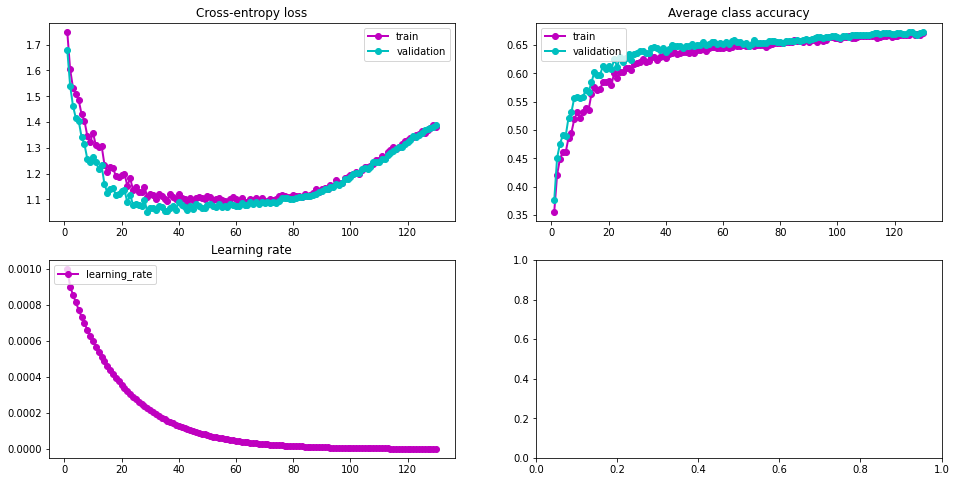

In [ ]:
print("alpha_f = 1")
def trainNetwork():
    plot_data = {}
    plot_data['train_loss'] = []
    plot_data['valid_loss'] = []
    plot_data['train_acc'] = []
    plot_data['valid_acc'] = []
    plot_data['lr'] = []
    SAVE_DIR = ROOT_DIR + '/plots'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    lossFunc = nn.CrossEntropyLoss()

    net = ConvolutionalModel(3, 16, 128, 10).to(device=device)

    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    epoch = num_epochs
    

    for e in range(epoch):

        net.train()

        if e == 75:
            optimizer = optim.Adam(net.parameters(), lr=scheduler.get_last_lr()[0], weight_decay=weight_decay)
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr']/2.0
            
            with torch.no_grad():
                net.train()
                for imgs, labels in unlabeled_loader:
                    imgs = imgs.to(device)
                    labels = labels.to(device)
                    outputs = net(imgs)
    
        accLoss = 0.0

        for i, data in enumerate(labeled_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            outputs = net(inputs)
            loss = lossFunc(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accLoss += loss.item()

            if (i+1) % 10 == 0:
                print("Epoch: %d, Labeled iteration: %5d, Loss: %.3f" % ((e + 1), (i+1), (accLoss / (i + 1))))
        
        if e >= T1:

            for j, data in enumerate(unlabeled_loader, 0):
                inputs, real_labels = data
                inputs = inputs.to(device=device)
                real_labels = real_labels.to(device=device)

                outputs = net(inputs)
                _, labels = torch.max(outputs,1)

                loss = alpha(e, T1, T2) * lossFunc(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                accLoss += loss.item()

                if (j+1) % 100 == 0:
                    print("Epoch: %d, Unlabeled iteration: %5d, Loss: %.3f" % ((e + 1), (j+1), (accLoss / (i + 1 + j +1))))
                    eq = torch.eq(labels, real_labels)
                    print(eq)
                    print(torch.sum(eq))
                    print(real_labels.shape)


        train_loss, train_acc, trainconf = evaluate(net, trainloader, lossFunc)
        val_loss, val_acc, valconf = evaluate(net, testloader, lossFunc)

        print('Epoch: {}, Training loss: {}, Training accuracy: {}'.format(e+1, train_loss, train_acc))
        print(trainconf)

        print('Epoch: {}, Test loss: {}, Test accuracy: {}'.format(e+1, val_loss, val_acc))
        print(valconf)
        specificMetrics(valconf)

        plot_data['train_loss'] += [train_loss]
        plot_data['valid_loss'] += [val_loss]
        plot_data['train_acc'] += [train_acc]
        plot_data['valid_acc'] += [val_acc]
        plot_data['lr'] += [scheduler.get_lr()]

        scheduler.step()

    plot_training_progress(SAVE_DIR, plot_data, '_250_500')
    PATH = ROOT_DIR+'/network/'+'net_a.pth'
    torch.save(net.state_dict(), PATH)


trainNetwork()